## Mujoco & GLFW
- Render mujoco without any viewer (utilize GLFW)
- Multiple cameras available

</p>

> ### Viewing order
>> 1. get mujoco model data & initialize glfw
>> 2. create glfw window
>> 3. setup scene & camera, append to list
>> 4. step & render through while loop
>> 
>
> ### About Camera
>> two camera IDs: -1 for overview, 0 for fixed egocentric (and other added camera) <br>
>> overview camera: free moving <br>
>> ego-centric camera: fixed to gripper base joint <br>

</p>

In [1]:
import mujoco

import numpy as np
import time

import glfw
import sys

import matplotlib.pyplot as plt

In [2]:
""" SETUP """

# 1-1. get model & data
model = mujoco.MjModel.from_xml_path('../ur5e_mjcf/scene.xml')
data = mujoco.MjData(model)

# return camera ID: mujoco viewer camera -> not included in camera ID (id -1)
# print(model.camera("egocentric").id)

In [3]:
# 1-2. lists for multiple cameras & windows
windows = []
contexts = [] # for mujoco context, not glfw
scenes = []
cameras = []
options = []
viewport=mujoco.MjrRect(0, 0, 0, 0)

if not glfw.init():
    sys.exit("couldn't initialize glfw")

# make mujoco context -> not neccessary...
# Attribute error: no attribute named mjr_makeContext // context generated before mjr_makeContext
# mujoco.mjr_makeContext(model, mujoco.MjrContext(model, mujoco.mjtFontScale.mjFONTSCALE_150))

In [4]:
# 1-3. create window and context

# 1-3-a. free camera

# create window
window = glfw.create_window(1280, 720, f"Camera: interactive", None, None)
# validate
if not window:
    glfw.terminate()
    raise RuntimeError("GLFW window creation failed")

# make glfw context
glfw.make_context_current(window)

# scene, camera, options
scene = mujoco.MjvScene(model, maxgeom=1000)
cam = mujoco.MjvCamera()
cam.type = mujoco.mjtCamera.mjCAMERA_FREE
opt = mujoco.MjvOption()

# append to list
scenes.append(scene)
cameras.append(cam)
options.append(opt)
windows.append(window)
contexts.append(mujoco.MjrContext(model, mujoco.mjtFontScale.mjFONTSCALE_150))

In [5]:
# 1-3-b. fixed camera

# create window
window = glfw.create_window(640, 480, f"Camera: egocentric fixed", None, None)
if not window:
    glfw.terminate()
    raise RuntimeError("GLFW window creation failed")

# make glfw context
glfw.make_context_current(window)

# scene, camera, options
scene = mujoco.MjvScene(model, maxgeom=1000)
cam = mujoco.MjvCamera()
cam.type = mujoco.mjtCamera.mjCAMERA_FIXED
cam.fixedcamid = 0
opt = mujoco.MjvOption()

# append to list
scenes.append(scene)
cameras.append(cam)
options.append(opt)
windows.append(window)
contexts.append(mujoco.MjrContext(model, mujoco.mjtFontScale.mjFONTSCALE_150))


# 1-4. set rendering interval
render_interval = 0.1
last_render_time = time.time()

In [6]:
""" GLFW CALLBACK: CAMERA MOVEMENT """

# 2-1. initialize global variable
last_x, last_y = 0, 0
mouse_button = None

# 2-2. define glfw callbacks

def mouse_button_callback(window, button, action, mods):
    global mouse_button
    if action == glfw.PRESS:
        mouse_button = button
        # print("mouse pressed")
    elif action == glfw.RELEASE:
        mouse_button = None

def cursor_pos_callback(window, xpos, ypos):
    global last_x, last_y, mouse_button
    dx = (xpos - last_x)/1000
    dy = (ypos - last_y)/1000
    last_x, last_y = xpos, ypos
    # print(f"mouse position: {xpos}, {ypos}")

    if mouse_button is not None:
        action = {
            glfw.MOUSE_BUTTON_LEFT: mujoco.mjtMouse.mjMOUSE_ROTATE_H,
            glfw.MOUSE_BUTTON_RIGHT: mujoco.mjtMouse.mjMOUSE_MOVE_H,
            glfw.MOUSE_BUTTON_MIDDLE: mujoco.mjtMouse.mjMOUSE_ZOOM
        }.get(mouse_button, None)

        if action is not None:
            mujoco.mjv_moveCamera(model, action, dx, dy, scenes[0], cameras[0])
            # print("cam moved")

def scroll_callback(window, xoffset, yoffset):
    # Zoom camera with scroll wheel
    mujoco.mjv_moveCamera(model, mujoco.mjtMouse.mjMOUSE_ZOOM, 0.0, -yoffset/100, scenes[0], cameras[0])
    # print(f"offsets x:{xoffset}, y:{yoffset}")


# 2-3. set glfw callbacks
glfw.set_mouse_button_callback(windows[0], mouse_button_callback)
glfw.set_cursor_pos_callback(windows[0], cursor_pos_callback)
glfw.set_scroll_callback(windows[0], scroll_callback)

In [7]:
globaol_height = 720
global_width = 1280

In [8]:
""" SIMULATION LOOP """

# 3-1. generate two actions
pos_1 = [0, -0.8, 2.5, 0, -0.3, 0]
pos_2 = [0.8, 1.3, 0.2, 0, -0.3, 0]
control_signal = pos_1
flag = 0
count = 0

init_time = time.time()

# while loop
while not any([glfw.window_should_close(win) for win in windows]):
    # make control signal

    if flag == 1 and time.time() - init_time > 5:
        control_signal = pos_2
        flag = 0
        init_time = time.time()
    elif flag == 0 and time.time() - init_time > 5:
        count=0
        control_signal = pos_1
        flag = 1
        init_time = time.time()

    # set input control
    data.ctrl = control_signal

    # step
    mujoco.mj_step(model, data)
    # print("steped")

    # determine frame rate
    current_time = time.time()

    if current_time - last_render_time >= render_interval:
        last_render_time = current_time

        for i, window in enumerate(windows):
            
            # print(f"making context for window {i}")
            # make context, set width & height
            glfw.make_context_current(window)
            width, height = glfw.get_framebuffer_size(window)
            global_width = width
            global_height = height
            viewport.width = width
            viewport.height = height

            # update scene & render
            mujoco.mjv_updateScene(model, data, options[i], None, cameras[i],
                                mujoco.mjtCatBit.mjCAT_ALL, scenes[i])
            mujoco.mjr_render(viewport, scenes[i], contexts[i])

            glfw.swap_buffers(window)

        glfw.poll_events()
        time.sleep(0.01)

# Clean up
glfw.terminate()

640 480


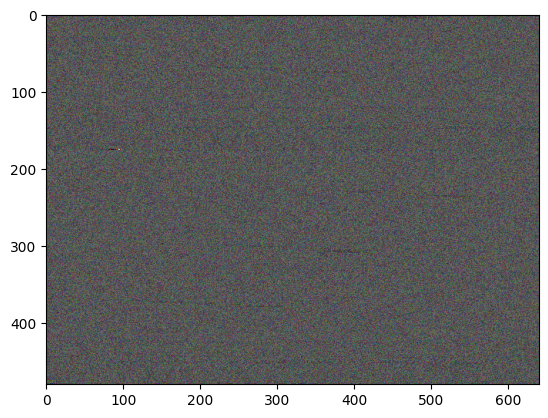

In [14]:
# additional: to get camera -> get pixels after context rendering

render_width = global_width
render_height = global_height

print(render_width, render_height)

rgb_pixels = np.empty((3, render_height,render_width), dtype=np.uint8)
# mujoco.mjr_readPixels(rgb_pixels, None, rect, context)
mujoco.mjr_readPixels(rgb_pixels, None, viewport, contexts[0])

image = rgb_pixels.reshape(render_height, render_width, 3)
# The image might be vertically flipped, you may need to flip it
image = np.flipud(image)

# show image
plt.imshow(image)
plt.show()
